In [1]:
!pip install mxnet-cu100mkl

     |████████████████████████████████| 576.6MB 28kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


#LS GAN (Least Square Generative Adversarial Networks) - MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu()

In [3]:
def transform(data):
    return data.reshape((784)).astype('float32')/255.0

train_mnist = gluon.data.vision.MNIST(train = True).transform_first(transform)

In [4]:
image, _ = train_mnist[1]
print(image.shape)

(784,)


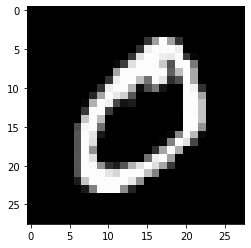

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
plt.show()

##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)

##Building the GAN model

There is just literally no difference between the model architectures of a vanilla gan and ls gan, only the loss function is difference.

The new loss still maintains the same logic of discriminator and generator being in an adversary, but uses least squares instead the concept of entropy, and doing this simplifieses and stabilises the training optimization for both discriminator and generator.... ultimately leading to better output results

In [0]:
# ===================== Discriminator Parameters ===========================
dw1 = nd.random.normal(0, 1, (784, 256), ctx = ctx) * 0.001
db1 = nd.random.normal(0, 1, 256, ctx = ctx) * 0.001

dw2 = nd.random.normal(0, 1, (256, 1), ctx = ctx) * 0.001
db2 = nd.random.normal(0, 1, 1, ctx = ctx) * 0.001
# ==========================================================================

# ======================= Generator Parameters =============================
gw1 = nd.random.normal(0, 1, (100, 256), ctx = ctx) * 0.001
gb1 = nd.random.normal(0, 1, 256, ctx = ctx) * 0.001

gw2 = nd.random.normal(0, 1, (256, 784), ctx = ctx) * 0.001
gb2 = nd.random.normal(0, 1, 784, ctx = ctx) * 0.001
# ==========================================================================

def leakyrelu(layer, alpha = 0.2):
    return nd.maximum(alpha * layer, layer)

def discriminator(x):
    layer1 = leakyrelu(nd.dot(x, dw1) + db1)
    predicted = nd.sigmoid(nd.dot(layer1, dw2) + db2)
    return predicted

def generator(z):
    layer1 = leakyrelu(nd.dot(z, gw1) + gb1)
    generated = nd.sigmoid(nd.dot(layer1, gw2) + gb2)
    return generated

dparams = [dw1, db1, dw2, db2]
gparams = [gw1, gb1, gw2, gb2]

# as we this is an scratch implementation, so we are gonna implement the optimizer from scratch too

dsqrs = [] # for adam optimizer
dvs = [] # for adam optimizer

gsqrs = [] # for adam optimizer
gvs = [] # for adam optimizer

for param in dparams:
    param.attach_grad()
    dsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    dvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    
for param in gparams:
    param.attach_grad()
    gsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    gvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability

In [0]:
def dloss(true, false):
    return nd.mean(nd.square(true - 1) + nd.square(false))/2.0

def gloss(false):
    return nd.mean(nd.square(false - 1))/2.0

In [0]:
def adam(t, params, vs, sqrs, lr = 0.001):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        grad = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(grad + 1e-8)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        update = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr + 1e-8) + eps)
        param[:] = param - update
        
def sgd(params, lr = 0.001):
    for param in params:
        param[:] = param - lr * param.grad

Epoch: 0 | Generator Loss: 0.36472 | Discirminator Loss: 0.08389


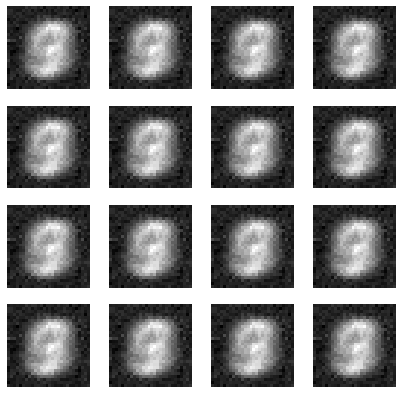

Epoch: 1 | Generator Loss: 0.48941 | Discirminator Loss: 0.00048


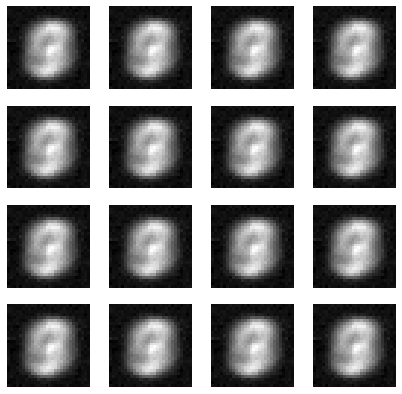

Epoch: 2 | Generator Loss: 0.49439 | Discirminator Loss: 0.00014


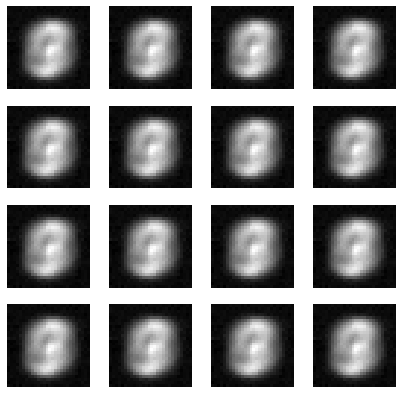

Epoch: 3 | Generator Loss: 0.49633 | Discirminator Loss: 0.00006


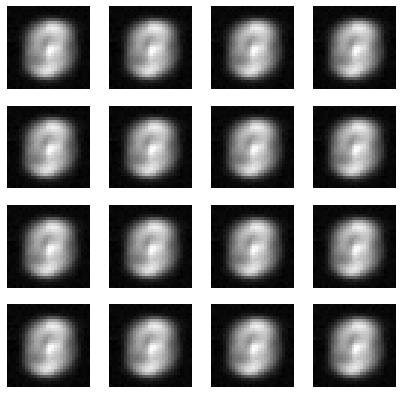

Epoch: 4 | Generator Loss: 0.49742 | Discirminator Loss: 0.00003


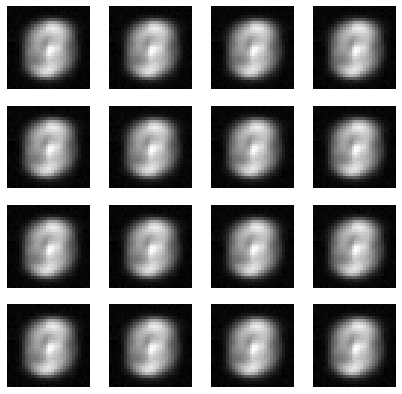

Epoch: 5 | Generator Loss: 0.49812 | Discirminator Loss: 0.00002


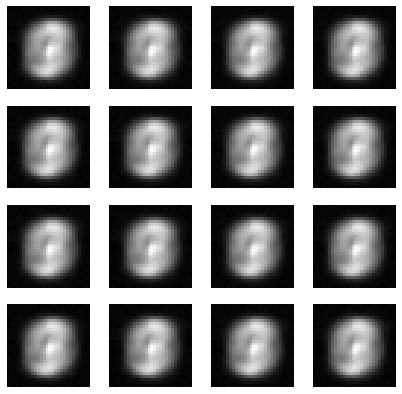

Epoch: 6 | Generator Loss: 0.49853 | Discirminator Loss: 0.00001


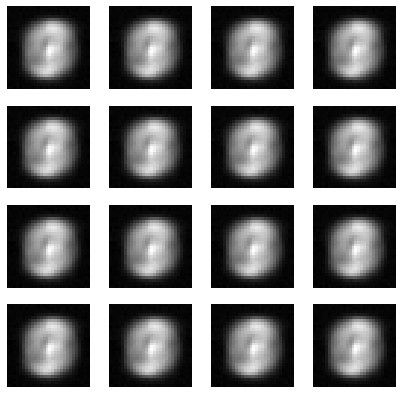

Epoch: 7 | Generator Loss: 0.49870 | Discirminator Loss: 0.00001


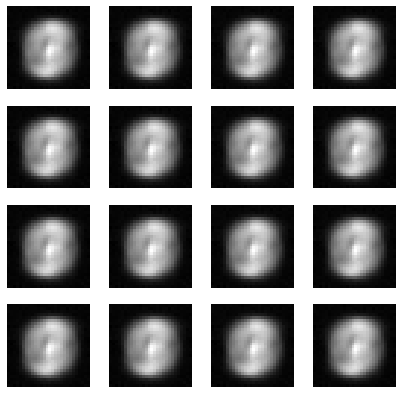

Epoch: 8 | Generator Loss: 0.49133 | Discirminator Loss: 0.01142


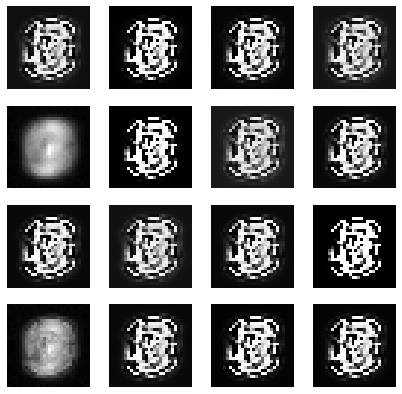

Epoch: 9 | Generator Loss: 0.50011 | Discirminator Loss: 0.00124


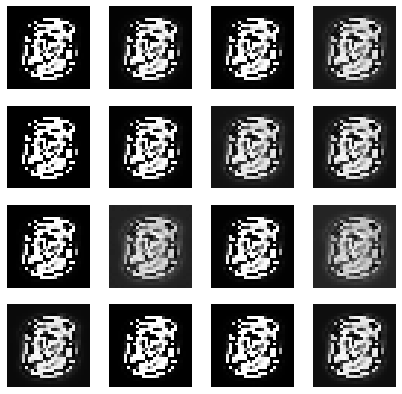

Epoch: 10 | Generator Loss: 0.49606 | Discirminator Loss: 0.00080


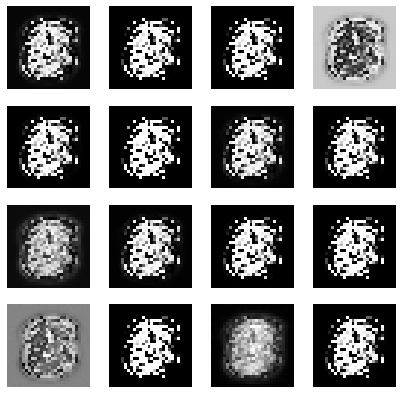

Epoch: 11 | Generator Loss: 0.49310 | Discirminator Loss: 0.00113


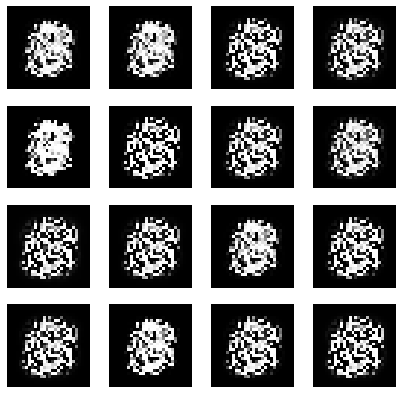

Epoch: 12 | Generator Loss: 0.49401 | Discirminator Loss: 0.00592


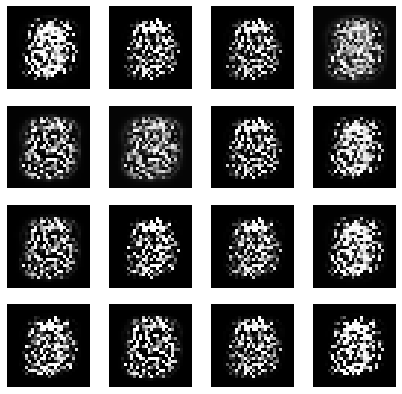

Epoch: 13 | Generator Loss: 0.49032 | Discirminator Loss: 0.00125


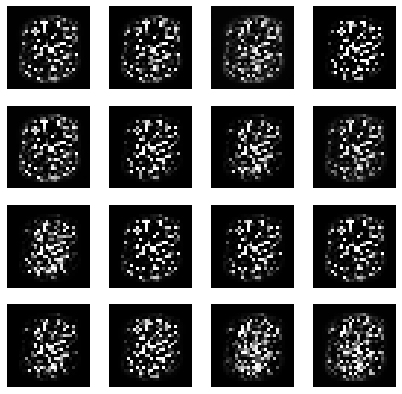

Epoch: 14 | Generator Loss: 0.49044 | Discirminator Loss: 0.00093


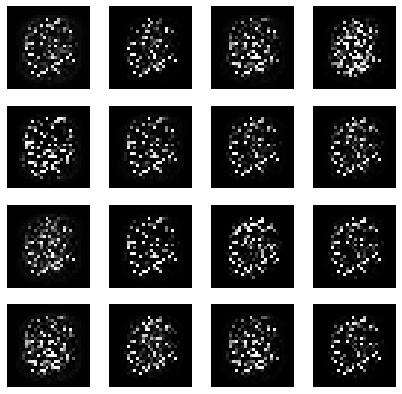

Epoch: 15 | Generator Loss: 0.49309 | Discirminator Loss: 0.00119


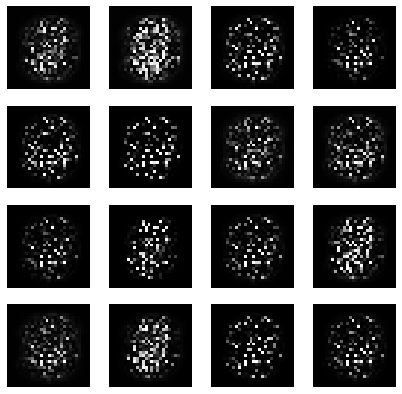

Epoch: 16 | Generator Loss: 0.49289 | Discirminator Loss: 0.00103


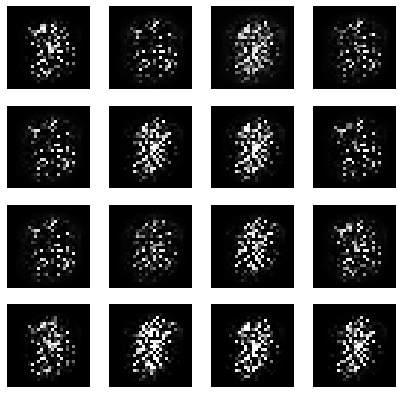

Epoch: 17 | Generator Loss: 0.49305 | Discirminator Loss: 0.00130


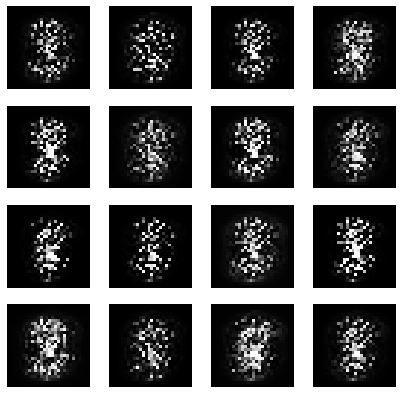

Epoch: 18 | Generator Loss: 0.49353 | Discirminator Loss: 0.00140


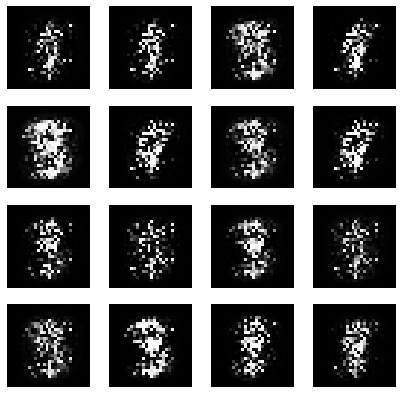

Epoch: 19 | Generator Loss: 0.49528 | Discirminator Loss: 0.00142


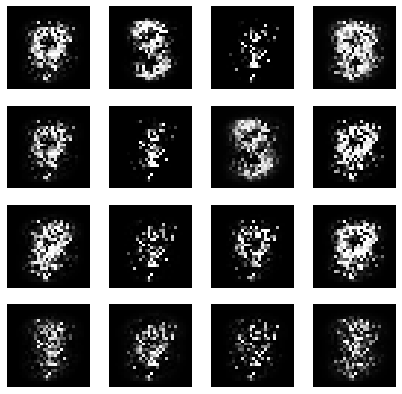

Epoch: 20 | Generator Loss: 0.49331 | Discirminator Loss: 0.00395


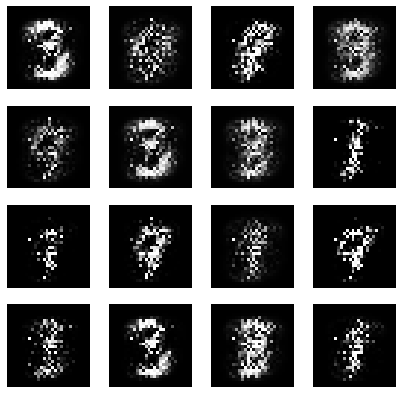

Epoch: 21 | Generator Loss: 0.49198 | Discirminator Loss: 0.00559


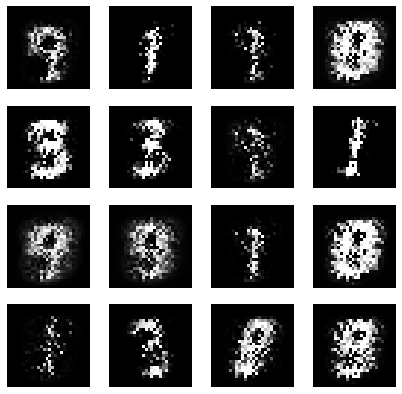

Epoch: 22 | Generator Loss: 0.49079 | Discirminator Loss: 0.00741


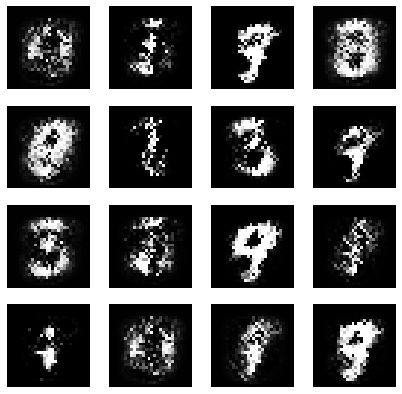

Epoch: 23 | Generator Loss: 0.48403 | Discirminator Loss: 0.01423


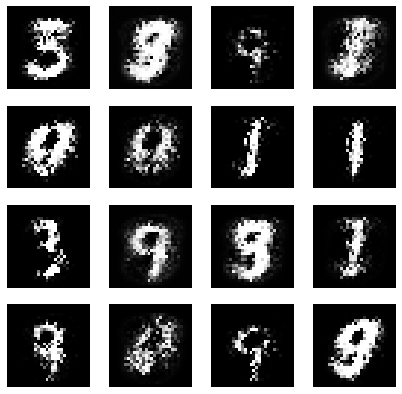

Epoch: 24 | Generator Loss: 0.48142 | Discirminator Loss: 0.01937


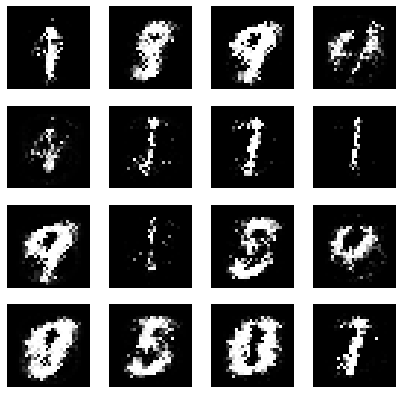

Epoch: 25 | Generator Loss: 0.47846 | Discirminator Loss: 0.02415


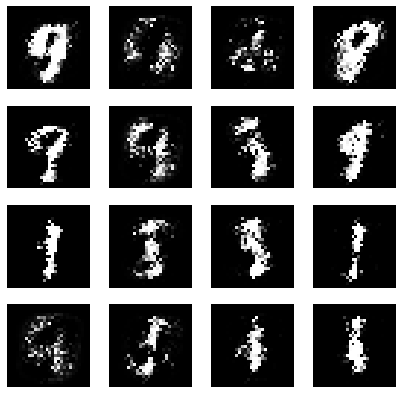

Epoch: 26 | Generator Loss: 0.47527 | Discirminator Loss: 0.02959


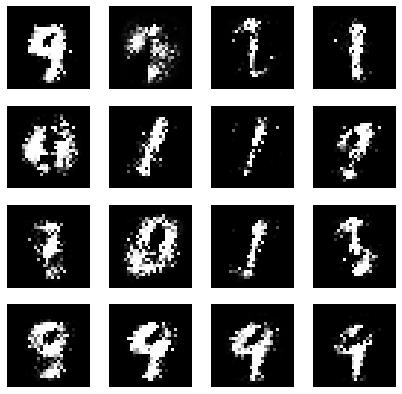

Epoch: 27 | Generator Loss: 0.47617 | Discirminator Loss: 0.02489


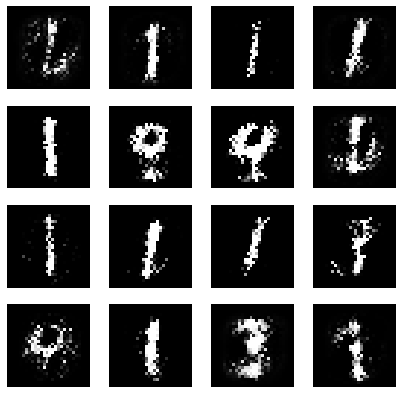

Epoch: 28 | Generator Loss: 0.47187 | Discirminator Loss: 0.03052


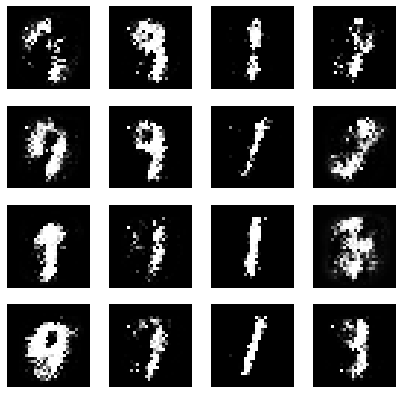

Epoch: 29 | Generator Loss: 0.46698 | Discirminator Loss: 0.03762


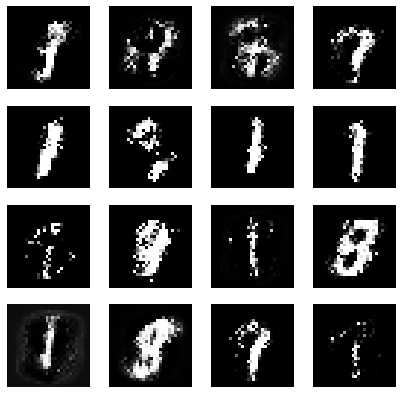

Epoch: 30 | Generator Loss: 0.46193 | Discirminator Loss: 0.04213


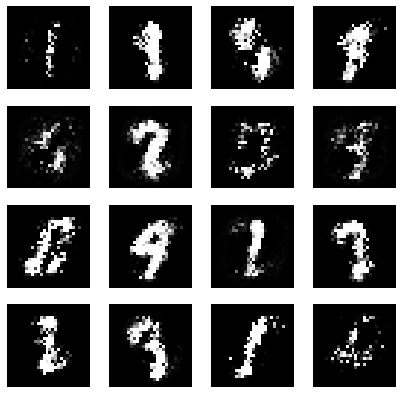

Epoch: 31 | Generator Loss: 0.45514 | Discirminator Loss: 0.05382


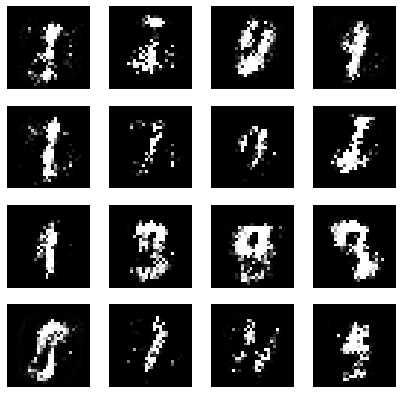

Epoch: 32 | Generator Loss: 0.45314 | Discirminator Loss: 0.05453


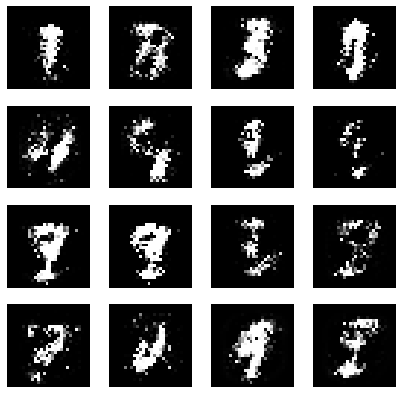

Epoch: 33 | Generator Loss: 0.43853 | Discirminator Loss: 0.07860


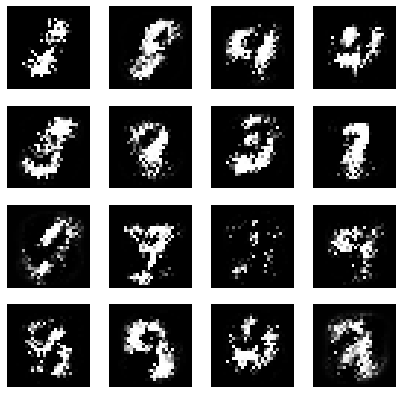

Epoch: 34 | Generator Loss: 0.42961 | Discirminator Loss: 0.08428


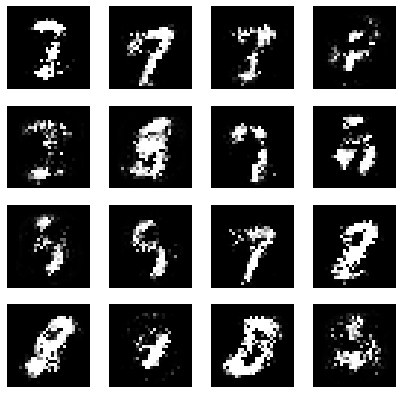

Epoch: 35 | Generator Loss: 0.41461 | Discirminator Loss: 0.09656


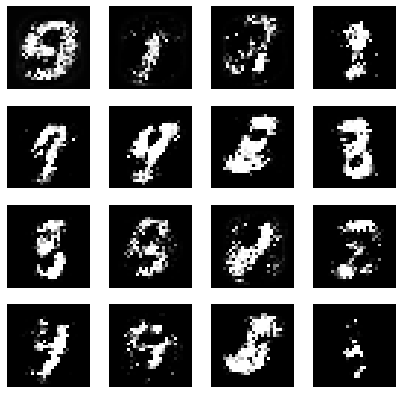

Epoch: 36 | Generator Loss: 0.41315 | Discirminator Loss: 0.09458


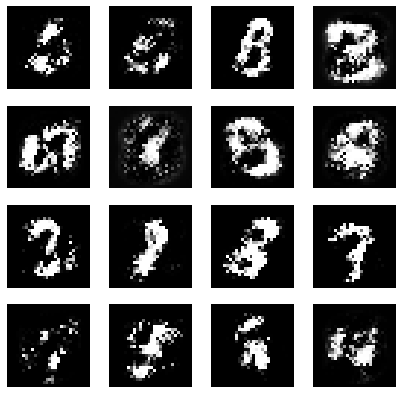

Epoch: 37 | Generator Loss: 0.40530 | Discirminator Loss: 0.09704


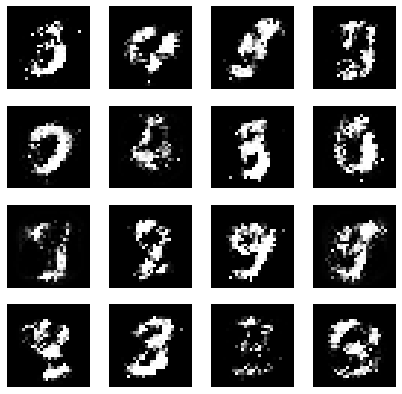

Epoch: 38 | Generator Loss: 0.39567 | Discirminator Loss: 0.10890


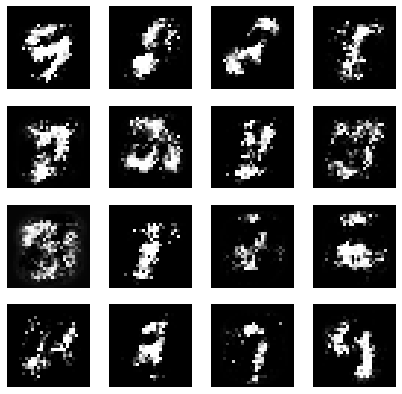

Epoch: 39 | Generator Loss: 0.39417 | Discirminator Loss: 0.10964


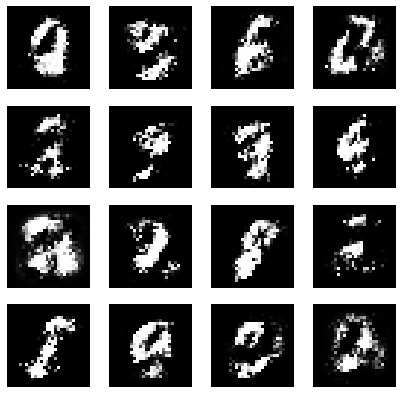

Epoch: 40 | Generator Loss: 0.38325 | Discirminator Loss: 0.11999


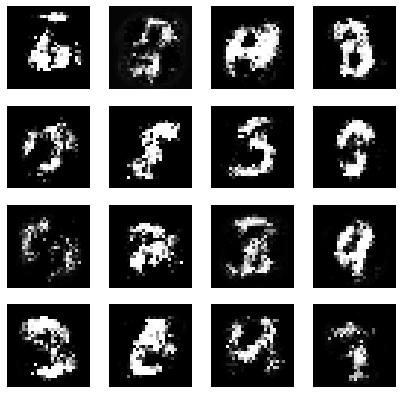

Epoch: 41 | Generator Loss: 0.38273 | Discirminator Loss: 0.12213


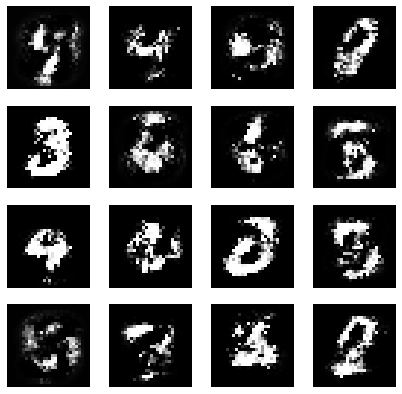

Epoch: 42 | Generator Loss: 0.38991 | Discirminator Loss: 0.11267


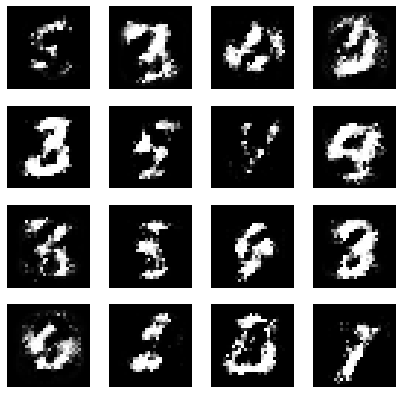

Epoch: 43 | Generator Loss: 0.39315 | Discirminator Loss: 0.10303


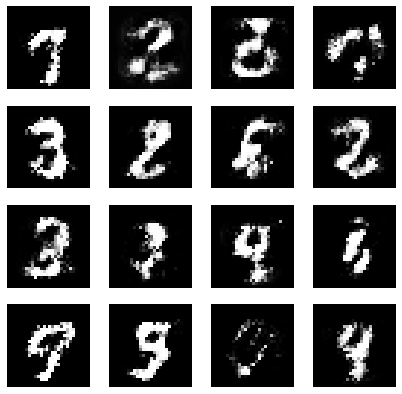

Epoch: 44 | Generator Loss: 0.39754 | Discirminator Loss: 0.10691


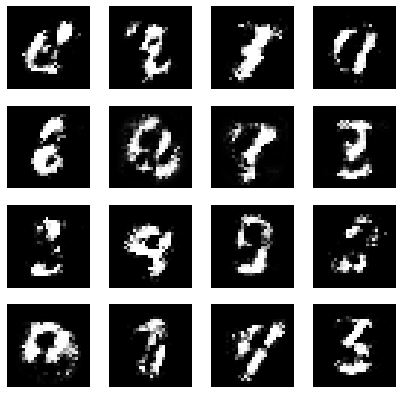

Epoch: 45 | Generator Loss: 0.39331 | Discirminator Loss: 0.11198


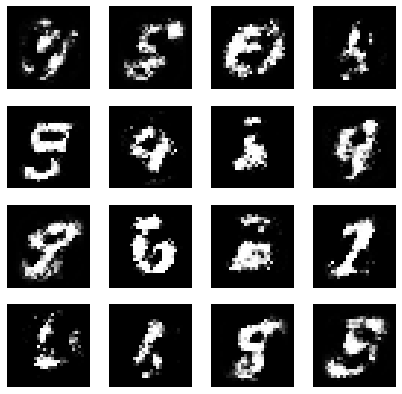

Epoch: 46 | Generator Loss: 0.39368 | Discirminator Loss: 0.10898


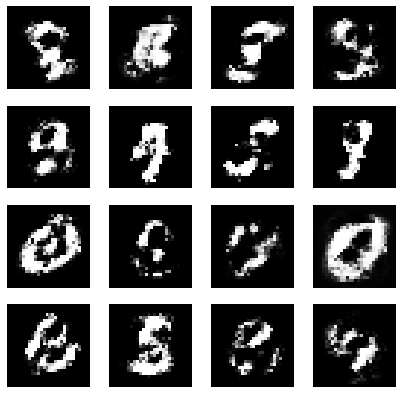

Epoch: 47 | Generator Loss: 0.39439 | Discirminator Loss: 0.11052


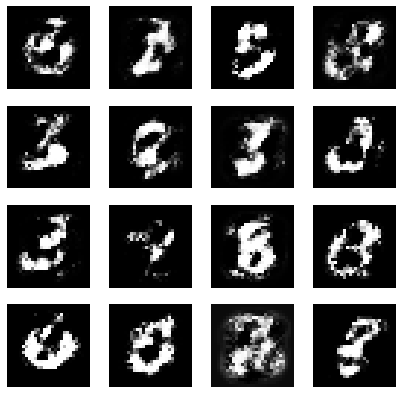

Epoch: 48 | Generator Loss: 0.39596 | Discirminator Loss: 0.10675


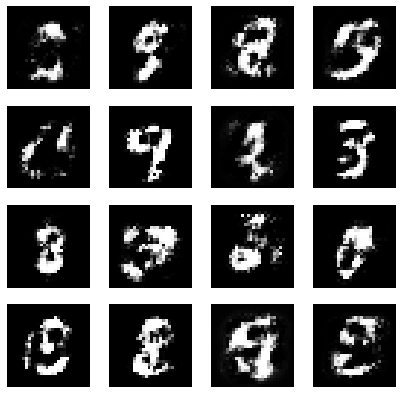

Epoch: 49 | Generator Loss: 0.40060 | Discirminator Loss: 0.09865


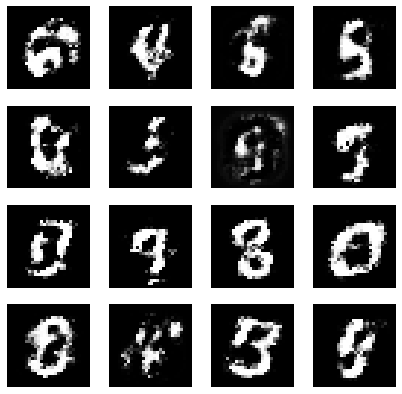

In [36]:
epochs = 50 # a gan usually takes a lot of epochs to work properly
num_batches = 60000//batch_size
learning_rate = 0.01

Glosses = []
Dlosses = []

t = 0
for epoch in range(epochs):
    gcum_loss = 0.0
    dcum_loss = 0.0
    for features, _ in training_data:
        # "features, _" because "_" are the labels of the features returned by training data loader,
        # which we don't need any more since we since we are going unsupervised generation of data, not classification
        t += 1
        features = features.as_in_context(ctx)
        z = nd.random.normal(0, 1, (features.shape[0], 100)).as_in_context(ctx)

        with autograd.record():
            generated = generator(z)
            false = discriminator(generated)
            true = discriminator(features)
            Dloss = dloss(true, false)
        Dloss.backward()
        adam(t, dparams, vs = dvs, sqrs = dsqrs, lr = learning_rate)

        with autograd.record():
            generated = generator(z)
            false = discriminator(generated)
            Gloss = gloss(false)
        Gloss.backward()
        adam(t, gparams, vs = gvs, sqrs = gsqrs, lr = learning_rate)
        
        gcum_loss += Gloss
        dcum_loss += Dloss
    
    Gloss = gcum_loss.asscalar()/num_batches
    Dloss = dcum_loss.asscalar()/num_batches
    
    Glosses.append(Gloss)
    Dlosses.append(Dloss)
    
    print(f'Epoch: {epoch} | Generator Loss: {Gloss:.5f} | Discirminator Loss: {Dloss:.5f}')
    
    plt.figure(figsize = (7, 7))
    for i, image in enumerate(generated[:16], 1):
        plt.subplot(4, 4, i)
        plt.imshow(image.reshape((28, 28)).asnumpy(), cmap = 'gray')
        plt.axis('off')
    plt.show()

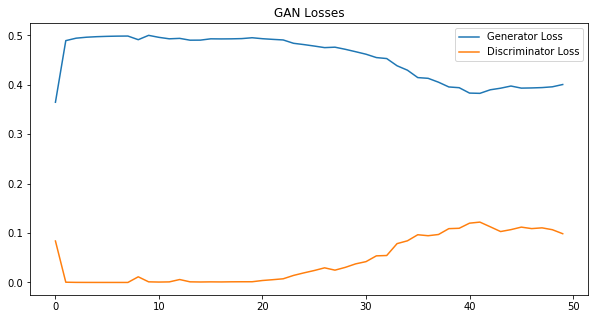

In [37]:
plt.figure(figsize = (10, 5))
plt.plot(Glosses, label = 'Generator Loss')
plt.plot(Dlosses, label = 'Discriminator Loss')
plt.legend()
plt.title('GAN Losses')
plt.show()